### Twitter Sentiment Analysis

There are various files in these archives: other than this README, each one can be identified by its filename, in the format {set}_{type}.{filetype}
- {set} refers to either train, dev, or test:


    train: You should use this data when building a model
    dev: You should use this data when evaluating a model
    test: You should submit the outputs on this data to Kaggle; the labels are not given
   
- {type} refers to either full, count, tfidf, glove100:
    
    
    full: This contains the raw text of the corresponding tweets, one tweet per line, in the following format:
          sentiment, tweet_id, tweet (newline)
         
where sentiment is the class label (to be predicted), the tweet_id identifies the tweet, and the Tweet-text the raw tweet

In [19]:
ls

Analysis.ipynb   dev_glove.csv    test_glove.csv   train_glove.csv
README.txt       dev_tfidf.csv    test_tfidf.csv   train_tfidf.csv
dev_count.csv    test_count.csv   train_count.csv  vocab.txt
dev_full.csv     test_full.csv    train_full.csv


In [23]:
import pandas as pd
import numpy as np
import re

from nltk import word_tokenize
from nltk.corpus import stopwords
from math import sqrt, floor

In [4]:
dataframe_full = pd.read_csv("train_full.csv")
print(f"Number of tweets : {dataframe_full.shape[0]}")
dataframe_full.head()

Number of tweets : 159253


,sentiment,tweet_id,tweet
0,neg,1,@bullyosullivan oh no! so sorry about your pet...
1,neg,2,@anneaam you should! i love prison break.i onl...
2,neg,3,i saw some really nice pair of shoess.. couldn...
3,neg,4,hihihi i had fun but my foot is still hurting!...
4,neg,5,sourish limbs is preventing me from gg out on ...


### Benchmarking
We first do some exploratory analysis and construct some basic benchmarks for model performance. As we see, the dataset is skewed towards `pos` and `neg` labels, which combine to make up $\approx80\%$ of the labels. Thus we can say that the dataset is slightly imbalanced, which might be problematic.

neg    0.407352
pos    0.392124
neu    0.200524
Name: sentiment, dtype: float64

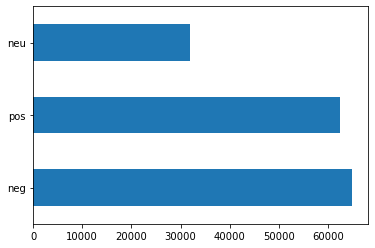

In [6]:
dataframe_full['sentiment'].value_counts().plot(kind='barh')
dataframe_full['sentiment'].value_counts(normalize=True)

### Feature engineering

So far our *features* involve only the actual tweet itself, we now engineer some additional features. Using several resources online, we can find some inspiration for engineering features in the NLP context. As an occasional twitter user, there is also some slight domain context for what suggests a tweets polarity, such as hashtags and mentions. We implement python functions below for performing feature extraction, we then apply these features to `dataframe_full`

In [11]:
stop_words = set(stopwords.words('english')) # we create this as a global variable
    

def num_chars(tweet: str):
    return len(tweet)


def num_words(tweet: str):
    return len(tweet.split())


def num_cap_words(tweet: str):
    return sum(map(str.isupper, tweet.split()))


def num_hashtags(tweet: str): 
    return tweet.count('#')


def num_mentions(tweet: str):
    return tweet.count('@')


def num_stopwords(tweet: str):  
    word_tokens = word_tokenize(tweet)
    stopwords_tweet = [w for w in word_tokens if w in stop_words]
    return len(stopwords_tweet)

In [10]:
engineered_features = [num_chars, num_words, num_cap_words, num_hashtags, num_mentions, 
                       num_stopwords]

for feature in engineered_features:         # this is just a fancy way to loop our feature functions and apply them
    dataframe_full[feature.__name__] = dataframe_full["tweet"].apply(lambda x: feature(x))

dataframe_full['avg_wordlength'] = dataframe_full['num_chars']/dataframe_full['num_words']
dataframe_full.head()

,sentiment,tweet_id,tweet,num_chars,num_words,num_cap_words,num_hashtags,num_mentions,num_stopwords,avg_wordlength
0,neg,1,@bullyosullivan oh no! so sorry about your pet...,50,8,0,0,1,4,6.250000
1,neg,2,@anneaam you should! i love prison break.i onl...,66,13,0,0,1,5,5.076923
2,neg,3,i saw some really nice pair of shoess.. couldn...,58,11,0,0,0,3,5.272727
3,neg,4,hihihi i had fun but my foot is still hurting!...,63,13,0,0,0,7,4.846154
4,neg,5,sourish limbs is preventing me from gg out on ...,135,29,0,0,0,18,4.655172


### Preprocesssing
Having engineered some features, our dataset is still *messy* and could be improved with some preprocessing of features before applying to a statisical learning algorithm.

In [28]:
def preprocess():
    return

### Linear classification models : Training

Having engineered several features from our dataset of tweets, we can begin to implement and train some classification models. We begin by applying linear classification models; ones that determine a linear decision boundary between class labels. If the engineered dataset is indeed linearly separable, we will see strong performance across these models.

In [14]:
# we first separate out our features from our labels and drop non-features such as tweet_id
df_full = dataframe_full            
y = df_full['sentiment']
X = df_full.drop(['sentiment', 'tweet_id', 'tweet'], 1)

assert y.shape[0] == X.shape[0]

In [17]:
from sklearn.linear_model import LogisticRegression

l2_logistic_regression = LogisticRegression(penalty='l2', random_state=0, max_iter=10000).fit(X, y)
l1_logistic_regression = LogisticRegression(penalty='none',random_state=0, max_iter=10000).fit(X, y)

In [18]:
from sklearn.naive_bayes import GaussianNB

gaussian_nb = GaussianNB().fit(X, y)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

L2_knn = KNeighborsClassifier(n_neighbors=floor(sqrt(X.shape[0]))).fit(X, y)

### Linear classification models : Testing

Having used `train_full` to train the model, we now turn to testing and evaluating the models using the `dev_full` dataset. As this dataset intially contains only `tweet_id` and `tweet` as features, we pass it through the same pipeline of feature engineering and preprocessing as our training dataset.

In [19]:
def transformation_pipeline(dataframe: pd.DataFrame):
    # applies the transformation pipeline to the testing data frame, return labels and feature matrix
    
    for feature in engineered_features:         
        dataframe[feature.__name__] = dataframe["tweet"].apply(lambda x: feature(x))
    
    dataframe['avg_wordlength'] = dataframe['num_chars']/dataframe['num_words']
    
    y = dataframe['sentiment']
    X = dataframe.drop(['sentiment', 'tweet_id', 'tweet'], 1)
    return X, y

In [27]:
from sklearn.metrics import accuracy_score

test_set = pd.read_csv("dev_full.csv")
X_test, y_test = transformation_pipeline(test_set)
print(f"{X.shape[0]} test instances")


# evaluation of Logistic Regression: 
l2_lr_pred = l2_logistic_regression.predict(X_test)
l1_lr_pred = l1_logistic_regression.predict(X_test)
print(f"L2 Logistic Regression Accuary score : {accuracy_score(l2_lr_pred, y_test)}")
print(f"L1 Logistic Regression Accuary score : {accuracy_score(l1_lr_pred, y_test)}\n")


# evaluation of Naive Bayes: 
nb_pred = gaussian_nb.predict(X_test)
print(f"Gaussian Naive Bayes Accuary score   : {accuracy_score(nb_pred, y_test)}\n")


# evaluation of kNN:
L2_kNN_pred = L2_knn.predict(X_test)
print(f"L2 kNN Accuary score   : {accuracy_score(L2_kNN_pred, y_test)}")

159253 test instances
L2 Logistic Regression Accuary score : 0.5689741786396062
L1 Logistic Regression Accuary score : 0.5694765397367628

Gaussian Naive Bayes Accuary score   : 0.5369235406410128

L2 kNN Accuary score   : 0.5599316788907867
